# Import

In [3]:
import pandas as pd
import ast
import os

# Paths & reading data

In [4]:
DATA_DIR = "../../Data"
movies = pd.read_csv(os.path.join(DATA_DIR, "movies_metadata.csv"), low_memory=False)
credits = pd.read_csv(os.path.join(DATA_DIR, "credits.csv"))
keywords = pd.read_csv(os.path.join(DATA_DIR, "keywords.csv"))

In [5]:
# Colonnes utiles dans movies_metadata
movies = movies[[
    "id", "title", "genres", "runtime", "budget",
    "vote_average", "vote_count", "popularity"
]]

# Conversion types
movies["id"] = pd.to_numeric(movies["id"], errors="coerce")
movies["budget"] = pd.to_numeric(movies["budget"], errors="coerce")
movies["runtime"] = pd.to_numeric(movies["runtime"], errors="coerce")

movies = movies.dropna(subset=["id", "title"])
movies["id"] = movies["id"].astype(int)

In [6]:
def parse_json_list(json_str, key):
    try:
        data = ast.literal_eval(json_str)
        return [item[key] for item in data]
    except:
        return []

In [7]:
movies["genres"] = movies["genres"].apply(lambda x: parse_json_list(x, "name"))
credits["actors"] = credits["cast"].apply(lambda x: parse_json_list(x, "name"))
credits["crew"] = credits["crew"].apply(lambda x: parse_json_list(x, "name"))
keywords["keywords"] = keywords["keywords"].apply(lambda x: parse_json_list(x, "name"))

In [8]:
df = movies.merge(
    credits[["id", "actors", "crew"]],
    on="id",
    how="left"
)

df = df.merge(
    keywords[["id", "keywords"]],
    on="id",
    how="left"
)

In [9]:
df["weighted_rating"] = (
    df["vote_average"] * df["vote_count"]
) / (df["vote_count"] + 100)

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42
)

In [11]:
from collections import Counter

actor_popularity = Counter()

for actors in train_df["actors"]:
    actor_popularity.update(actors)


In [12]:
crew_popularity = Counter()

for crew in train_df["crew"]:
    crew_popularity.update(crew)


In [13]:
def popularity_features(names, popularity_dict):
    # Si NaN ou pas une liste
    if not isinstance(names, list) or len(names) == 0:
        return 0.0, 0.0, 0

    pops = [popularity_dict.get(name, 0) for name in names]

    return (
        sum(pops) / len(pops),   # popularité moyenne
        max(pops),               # popularité max
        sum(p > 5 for p in pops) # nb de personnes "connues"
    )


In [14]:
train_df[[
    "actor_pop_mean",
    "actor_pop_max",
    "actor_pop_known"
]] = train_df["actors"].apply(
    lambda x: pd.Series(popularity_features(x, actor_popularity))
)

test_df[[
    "actor_pop_mean",
    "actor_pop_max",
    "actor_pop_known"
]] = test_df["actors"].apply(
    lambda x: pd.Series(popularity_features(x, actor_popularity))
)


In [15]:
train_df[[
    "crew_pop_mean",
    "crew_pop_max",
    "crew_pop_known"
]] = train_df["crew"].apply(
    lambda x: pd.Series(popularity_features(x, crew_popularity))
)

test_df[[
    "crew_pop_mean",
    "crew_pop_max",
    "crew_pop_known"
]] = test_df["crew"].apply(
    lambda x: pd.Series(popularity_features(x, crew_popularity))
)


In [16]:
train_df[[
    "actor_pop_mean", "actor_pop_max", "actor_pop_known",
    "crew_pop_mean", "crew_pop_max", "crew_pop_known"
]].describe()


,actor_pop_mean,actor_pop_max,actor_pop_known,crew_pop_mean,crew_pop_max,crew_pop_known
count,37300.000000,37300.000000,37300.000000,37300.000000,37300.000000,37300.000000
mean,10.470147,31.556005,5.783164,9.653932,26.166676,4.542708
std,8.635252,26.485943,6.254640,9.759163,32.159583,7.160077
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.750000,10.000000,1.000000,3.000000,5.000000,0.000000
50%,8.500000,27.000000,4.000000,6.647059,14.000000,2.000000
75%,15.357143,47.000000,8.000000,12.928571,34.000000,6.000000
max,121.000000,196.000000,140.000000,122.000000,214.000000,90.000000


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [17]:
# 1. Gérer les valeurs manquantes
print("Gestion des valeurs manquantes...")
train_df = train_df.copy()
test_df = test_df.copy()

# Remplir les NaN pour les colonnes numériques
numeric_cols = ['budget', 'runtime', 'popularity', 'vote_count', 
                'actor_pop_mean', 'actor_pop_max', 'actor_pop_known',
                'crew_pop_mean', 'crew_pop_max', 'crew_pop_known']

Gestion des valeurs manquantes...


In [18]:
# 1. Gérer les valeurs manquantes
print("Gestion des valeurs manquantes...")
train_df = train_df.copy()
test_df = test_df.copy()

Gestion des valeurs manquantes...


In [19]:
# Remplir les NaN pour les colonnes numériques
numeric_cols = ['budget', 'runtime', 'popularity', 'vote_count', 
                'actor_pop_mean', 'actor_pop_max', 'actor_pop_known',
                'crew_pop_mean', 'crew_pop_max', 'crew_pop_known']

In [20]:
for col in numeric_cols:
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

In [36]:
# Gérer les listes vides pour genres
train_df['genres'] = train_df['genres'].apply(lambda x: x if isinstance(x, list) and len(x) > 0 else ['Unknown'])
test_df['genres'] = test_df['genres'].apply(lambda x: x if isinstance(x, list) and len(x) > 0 else ['Unknown'])

# Ajouter des features d'ingénierie: nombre d'acteurs, réalisateurs, genres, keywords
train_df['num_actors'] = train_df['actors'].apply(lambda x: len(x) if isinstance(x, list) else 0)
test_df['num_actors'] = test_df['actors'].apply(lambda x: len(x) if isinstance(x, list) else 0)

train_df['num_crew'] = train_df['crew'].apply(lambda x: len(x) if isinstance(x, list) else 0)
test_df['num_crew'] = test_df['crew'].apply(lambda x: len(x) if isinstance(x, list) else 0)

train_df['num_genres'] = train_df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
test_df['num_genres'] = test_df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)

train_df['num_keywords'] = train_df['keywords'].apply(lambda x: len(x) if isinstance(x, list) else 0)
test_df['num_keywords'] = test_df['keywords'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [37]:
# 2. Encoder les genres (Multi-Hot encoding)
print("Encodage des genres...")
mlb = MultiLabelBinarizer()
train_genres_encoded = mlb.fit_transform(train_df['genres'])
test_genres_encoded = mlb.transform(test_df['genres'])

Encodage des genres...


In [38]:
# Créer des DataFrames pour les genres
train_genres_df = pd.DataFrame(
    train_genres_encoded, 
    columns=[f'genre_{g}' for g in mlb.classes_],
    index=train_df.index
)
test_genres_df = pd.DataFrame(
    test_genres_encoded, 
    columns=[f'genre_{g}' for g in mlb.classes_],
    index=test_df.index
)

In [39]:
# 3. Préparer les features (X) et la cible (y)
print("Préparation des features...")

# Features numériques à utiliser - AMÉLIORÉ avec nouvelles features
feature_cols = [
    'budget', 'runtime', 'popularity', 'vote_count',
    'actor_pop_mean', 'actor_pop_max', 'actor_pop_known',
    'crew_pop_mean', 'crew_pop_max', 'crew_pop_known',
    'num_actors', 'num_crew', 'num_genres', 'num_keywords'
]

X_train_numeric = train_df[feature_cols]
X_test_numeric = test_df[feature_cols]


Préparation des features...


In [40]:
# Combiner avec les genres
X_train = pd.concat([X_train_numeric.reset_index(drop=True), 
                     train_genres_df.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_numeric.reset_index(drop=True), 
                    test_genres_df.reset_index(drop=True)], axis=1)

In [41]:
# Variable cible
y_train = train_df['vote_average'].values
y_test = test_df['vote_average'].values

In [42]:
# Supprimer les lignes avec des notes manquantes
train_mask = ~np.isnan(y_train)
test_mask = ~np.isnan(y_test)

In [43]:
X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

In [44]:
print(f"Taille train: {X_train.shape}, Taille test: {X_test.shape}")


Taille train: (37300, 35), Taille test: (9325, 35)


In [45]:
# 4. Normalisation des features
print("Normalisation des données...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Normalisation des données...


In [52]:
print("\nConstruction et entraînement du réseau de neurones AMÉLIORÉ...")

# Création du modèle MLP avec hyperparamètres optimisés
model = MLPRegressor(
    hidden_layer_sizes=(256, 256, 128, 128, 64, 32),  # Architecture plus profonde
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    learning_rate='adaptive',  # Ajuster le learning rate automatiquement
    max_iter=300,  # Plus d'itérations
    batch_size=16,  # Batch size plus petit pour meilleure convergence
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,  # Plus de patience
    alpha=0.0001,  # L2 regularization (pour éviter l'overfitting)
    random_state=42,
    verbose=1
)



Construction et entraînement du réseau de neurones AMÉLIORÉ...


In [53]:
# Entraînement du modèle
model.fit(X_train_scaled, y_train)

Iteration 1, loss = 2.02108913
Validation score: 0.117970
Iteration 2, loss = 1.66049812
Validation score: 0.063565
Iteration 3, loss = 1.60729059
Validation score: 0.141171
Iteration 4, loss = 1.58209726
Validation score: 0.149914
Iteration 5, loss = 1.55281876
Validation score: 0.185166
Iteration 6, loss = 1.53302946
Validation score: 0.188178
Iteration 7, loss = 1.50846342
Validation score: 0.192853
Iteration 8, loss = 1.48918506
Validation score: 0.194061
Iteration 9, loss = 1.47897476
Validation score: 0.202851
Iteration 10, loss = 1.45210537
Validation score: 0.210256
Iteration 11, loss = 1.43122829
Validation score: 0.225064
Iteration 12, loss = 1.42158399
Validation score: 0.230242
Iteration 13, loss = 1.40301812
Validation score: 0.227395
Iteration 14, loss = 1.38547127
Validation score: 0.210023
Iteration 15, loss = 1.38178583
Validation score: 0.212306
Iteration 16, loss = 1.35933583
Validation score: 0.229018
Iteration 17, loss = 1.35282548
Validation score: 0.207582
Iterat

,"loss loss: {'squared_error', 'poisson'}, default='squared_error'The loss function to use when training the weights. Note that the""squared error"" and ""poisson"" losses actually implement""half squares error"" and ""half poisson deviance"" to simplify thecomputation of the gradient. Furthermore, the ""poisson"" loss internally usesa log-link (exponential as the output activation function) and requires``y >= 0``... versionchanged:: 1.7 Added parameter `loss` and option 'poisson'.",'squared_error'
,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(256, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the regressor will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",16
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate ``learning_rate_`` at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when solver='sgd'.",'adaptive'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",300
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True


In [54]:
print("\nÉvaluation sur le test set...")

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n{'='*50}")
print(f"RÉSULTATS")
print(f"{'='*50}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"{'='*50}")


Évaluation sur le test set...

RÉSULTATS
RMSE: 1.6881
MAE: 1.1666
R² Score: 0.2224


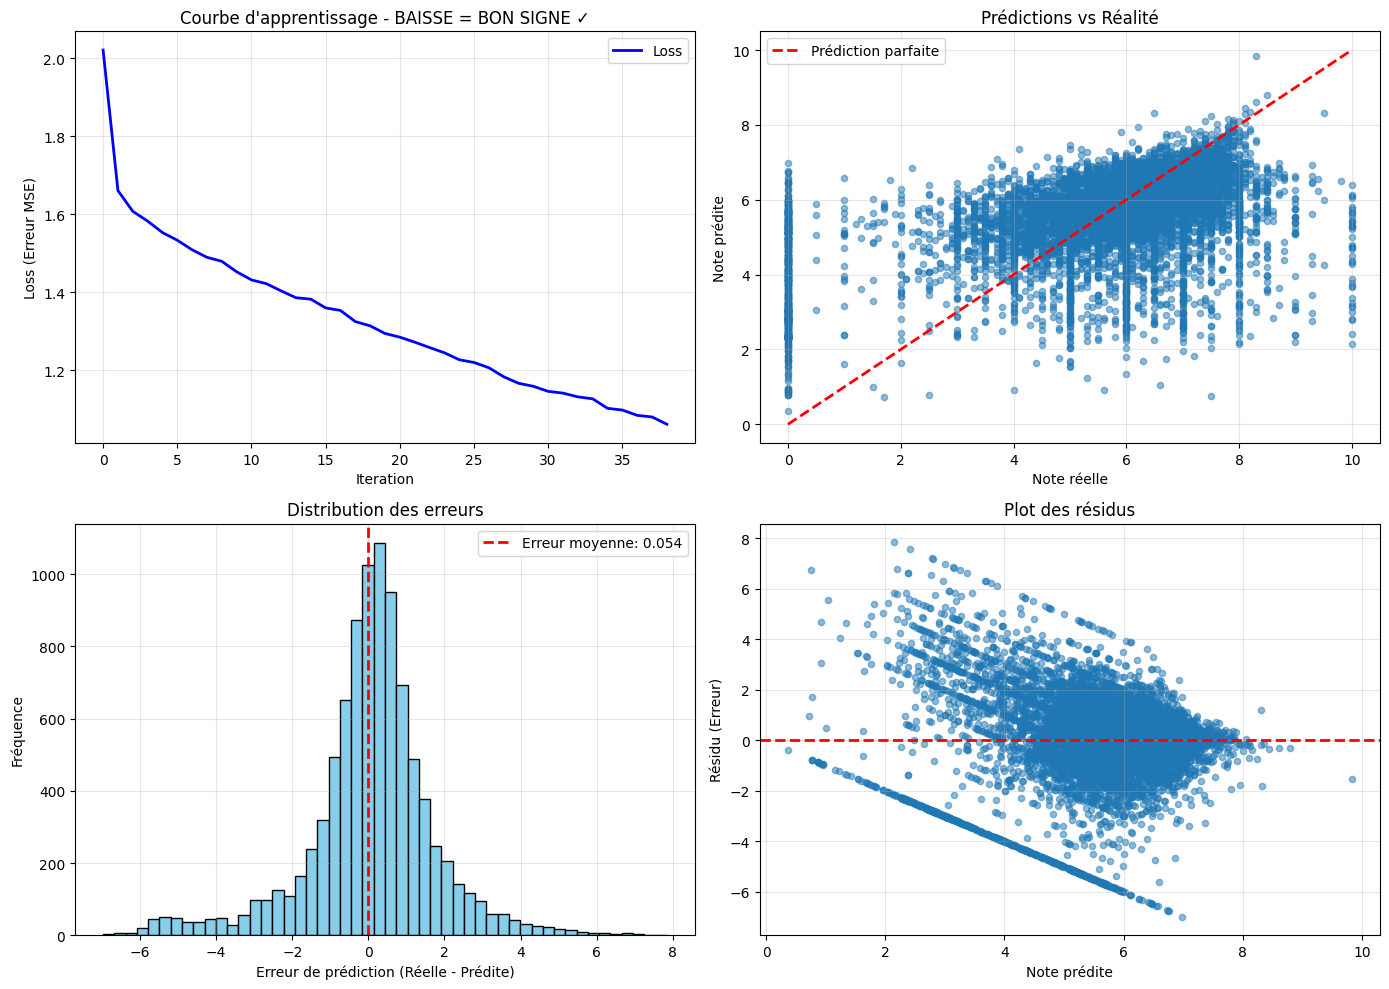


DIAGNOSTIC DE LA COURBE D'APPRENTISSAGE
✓ La loss DIMINUE = Le modèle apprend correctement
  Loss initiale: 2.0211
  Loss finale: 1.0608
  Réduction: 47.5%

✓ Métriques finales:
  RMSE: 1.6881 (plus bas = mieux)
  MAE: 1.1666 (plus bas = mieux)
  R²: 0.2224 (plus proche de 1 = mieux)


In [55]:
# Visualisations améliorées avec explications
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Courbe d'apprentissage (Loss)
axes[0, 0].plot(model.loss_curve_, linewidth=2, color='blue', label='Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss (Erreur MSE)')
axes[0, 0].set_title('Courbe d\'apprentissage - BAISSE = BON SIGNE ✓')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Prédictions vs Réalité
axes[0, 1].scatter(y_test, y_pred, alpha=0.5, s=20)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prédiction parfaite')
axes[0, 1].set_xlabel('Note réelle')
axes[0, 1].set_ylabel('Note prédite')
axes[0, 1].set_title('Prédictions vs Réalité')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution des erreurs
errors = y_test - y_pred
axes[1, 0].hist(errors, bins=50, edgecolor='black', color='skyblue')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2, label=f'Erreur moyenne: {errors.mean():.3f}')
axes[1, 0].set_xlabel('Erreur de prédiction (Réelle - Prédite)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des erreurs')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Résidus
axes[1, 1].scatter(y_pred, errors, alpha=0.5, s=20)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Note prédite')
axes[1, 1].set_ylabel('Résidu (Erreur)')
axes[1, 1].set_title('Plot des résidus')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Diagnostique
print("\n" + "="*60)
print("DIAGNOSTIC DE LA COURBE D'APPRENTISSAGE")
print("="*60)
print("✓ La loss DIMINUE = Le modèle apprend correctement")
print(f"  Loss initiale: {model.loss_curve_[0]:.4f}")
print(f"  Loss finale: {model.loss_curve_[-1]:.4f}")
print(f"  Réduction: {((model.loss_curve_[0] - model.loss_curve_[-1]) / model.loss_curve_[0] * 100):.1f}%")
print(f"\n✓ Métriques finales:")
print(f"  RMSE: {rmse:.4f} (plus bas = mieux)")
print(f"  MAE: {mae:.4f} (plus bas = mieux)")
print(f"  R²: {r2:.4f} (plus proche de 1 = mieux)")
print("="*60)


In [56]:
print("\nExemples de prédictions:")
print(f"{'Titre':<40} {'Réelle':<10} {'Prédite':<10} {'Erreur':<10}")
print("="*70)

# Identifier les prédictions les meilleures et les pires
errors_abs = np.abs(y_test - y_pred)
top_indices = np.argsort(errors_abs)[:10]  # 10 meilleures prédictions
worst_indices = np.argsort(errors_abs)[-10:]  # 10 pires prédictions

print("\nMeilleures prédictions:")
for idx in top_indices[:5]:
    if test_mask[idx]:
        test_idx = test_df.index[idx]
        title = str(test_df.loc[test_idx, 'title'])[:37] + '...' if len(str(test_df.loc[test_idx, 'title'])) > 40 else str(test_df.loc[test_idx, 'title'])
        print(f"{title:<40} {y_test[idx]:<10.2f} {y_pred[idx]:<10.2f} {y_test[idx]-y_pred[idx]:<10.2f}")

print("\nPires prédictions:")
for idx in worst_indices[-5:]:
    if test_mask[idx]:
        test_idx = test_df.index[idx]
        title = str(test_df.loc[test_idx, 'title'])[:37] + '...' if len(str(test_df.loc[test_idx, 'title'])) > 40 else str(test_df.loc[test_idx, 'title'])
        print(f"{title:<40} {y_test[idx]:<10.2f} {y_pred[idx]:<10.2f} {y_test[idx]-y_pred[idx]:<10.2f}")

# Sauvegarder le modèle
import joblib
joblib.dump(model, 'movie_rating_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModèle et scaler sauvegardés")



Exemples de prédictions:
Titre                                    Réelle     Prédite    Erreur    

Meilleures prédictions:
IMAX Mummies Secrets Of The Pharohs      6.90       6.90       -0.00     
I Remember Mama                          6.80       6.80       -0.00     
The Rebel                                6.50       6.50       0.00      
Lemon Popsicle                           6.60       6.60       -0.00     
Halo Legends                             6.90       6.90       0.00      

Pires prédictions:
Running Wild                             10.00      3.00       7.00      
Portrait of a Young Man in Three Move... 10.00      2.81       7.19      
Lo Sound Desert                          10.00      2.78       7.22      
In Search of Ancient Astronauts          10.00      2.42       7.58      
Claymation Comedy of Horrors             10.00      2.15       7.85      

Modèle et scaler sauvegardés




COMPARAISON AVEC GRADIENT BOOSTING:

Entraînement du Gradient Boosting...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           3.2709           0.4681           51.21s
         2           2.9448           0.5402           49.36s
         3           2.6280           0.2334           48.81s
         4           2.3860           0.2576           48.07s
         5           2.1751           0.1620           47.69s
         6           2.0188           0.1927           47.52s
         7           1.8567           0.0253           47.63s
         8           1.7811           0.2483           47.78s
         9           1.6824           0.0628           47.54s
        10           1.6125           0.0954           47.19s
        20           1.2863          -0.0478           44.66s
        30           1.2092          -0.0839           41.68s
        40           1.1816          -0.0260           39.87s
        50           1.1541          -0.0147           

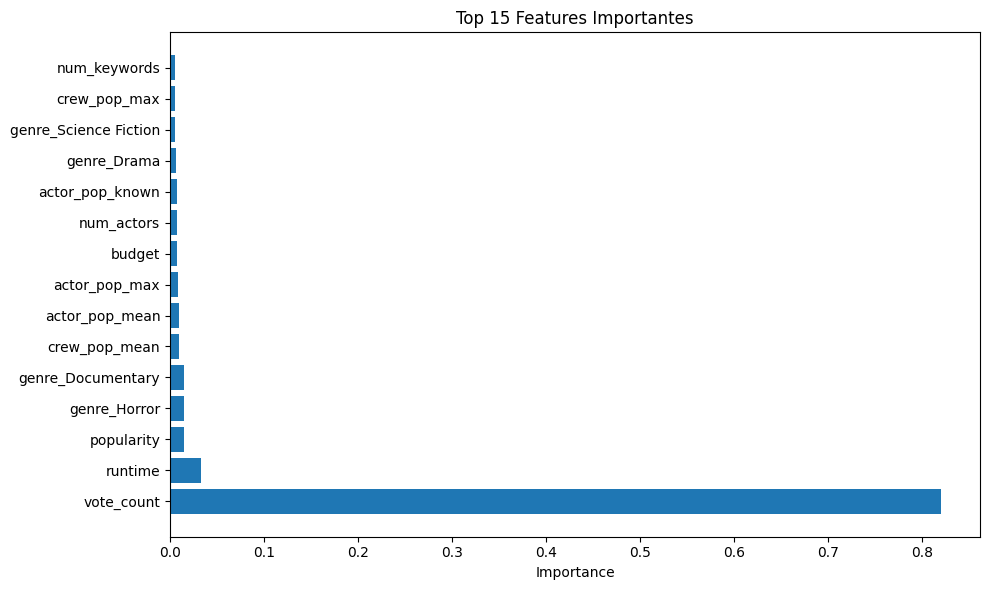


✓ Gradient Boosting est meilleur! Sauvegarde en cours...


In [ ]:
# ========== ESSAYER ENSEMBLE LEARNING (GRADIENT BOOSTING) ==========
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

print("\n\nCOMPARAISON AVEC GRADIENT BOOSTING:")
print("="*50)

# Créer un modèle Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42,
    verbose=1
)

# Entraîner le modèle
print("\nEntraînement du Gradient Boosting...")
gb_model.fit(X_train_scaled, y_train)

# Évaluation
y_pred_gb = gb_model.predict(X_test_scaled)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"\nRÉSULTATS GRADIENT BOOSTING:")
print(f"RMSE: {rmse_gb:.4f}")
print(f"MAE: {mae_gb:.4f}")
print(f"R² Score: {r2_gb:.4f}")

# Comparaison
print(f"\n{'COMPARAISON':<25} {'MLP':<15} {'Gradient Boost':<15} {'Gain %':<15}")
print("="*70)
print(f"{'RMSE':<25} {rmse:<15.4f} {rmse_gb:<15.4f} {((rmse-rmse_gb)/rmse)*100:<15.2f}%")
print(f"{'MAE':<25} {mae:<15.4f} {mae_gb:<15.4f} {((mae-mae_gb)/mae)*100:<15.2f}%")
print(f"{'R² Score':<25} {r2:<15.4f} {r2_gb:<15.4f} {((r2_gb-r2)/r2)*100:<15.2f}%")

# Feature importance
print("\n\nTop 10 Features importantes (Gradient Boosting):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

# Visualiser feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(15)['feature'], feature_importance.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Features Importantes')
plt.tight_layout()
plt.show()

# # Sauvegarder le meilleur modèle
# if rmse_gb < rmse:
#     print("\n✓ Gradient Boosting est meilleur! Sauvegarde en cours...")
#     joblib.dump(gb_model, 'movie_rating_model_best.pkl')
#     best_model = gb_model
# else:
#     print("\n✓ MLP est meilleur! Sauvegarde en cours...")
#     joblib.dump(model, 'movie_rating_model_best.pkl')
#     best_model = model
